<a href="https://colab.research.google.com/github/indra622/AIAcademy_SpeechRecognition/blob/main/3_RNN_and_CTC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN & CTC

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### library import

In [2]:
import torch
import torchaudio  #feature extraction
import torch.nn as nn   # RNN module 
import IPython.display as ipd
import matplotlib.pyplot as plt  #for visualization

## CTC train data download


In [3]:
!wget https://github.com/indra622/AIAcademy_SpeechRecognition/raw/main/set.wav

--2022-07-20 10:04:56--  https://github.com/indra622/AIAcademy_SpeechRecognition/raw/main/set.wav
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/set.wav [following]
--2022-07-20 10:04:56--  https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/set.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18998 (19K) [audio/wav]
Saving to: ‘set.wav.9’

set.wav.9           100%[===================>]  18.55K  --.-KB/s    in 0.001s  

2022-07-20 10:04:56 (26.1 MB/s) - ‘set.wav.9’ saved [18998/18998]



In [4]:
!ls -hl

total 204K
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data
-rw-r--r-- 1 root root  19K Jul 20 04:43 set.wav
-rw-r--r-- 1 root root  19K Jul 20 05:56 set.wav.1
-rw-r--r-- 1 root root  19K Jul 20 06:15 set.wav.2
-rw-r--r-- 1 root root  19K Jul 20 06:16 set.wav.3
-rw-r--r-- 1 root root  19K Jul 20 06:20 set.wav.4
-rw-r--r-- 1 root root  19K Jul 20 09:15 set.wav.5
-rw-r--r-- 1 root root  19K Jul 20 09:15 set.wav.6
-rw-r--r-- 1 root root  19K Jul 20 10:01 set.wav.7
-rw-r--r-- 1 root root  19K Jul 20 10:02 set.wav.8
-rw-r--r-- 1 root root  19K Jul 20 10:04 set.wav.9


### data check

In [5]:
ipd.Audio("./set.wav")

In [6]:
y,sr = torchaudio.load("./set.wav")

In [7]:
y.shape,sr

(torch.Size([1, 9424]), 16000)

In [8]:
9424 / 16000

0.589

### audio feature extraction

In [9]:
n_fft = 512
n_mels= 64
hop_length = n_fft//2
mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,n_mels=n_mels,hop_length=hop_length)
db_converter= torchaudio.transforms.AmplitudeToDB()

In [10]:
mel_spec = mel_converter(y)
mel_spec = db_converter(mel_spec)

### wave plot

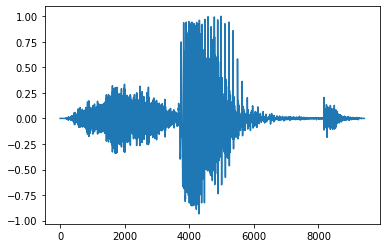

In [11]:
plt.plot(y[0])

### mel-spectrogram

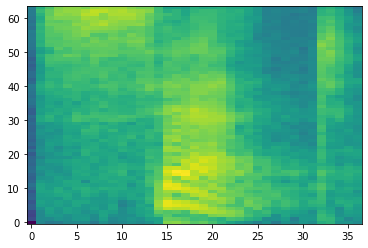

In [12]:
plt.imshow(mel_spec[0],origin='lower',aspect='auto',interpolation='nearest')

### shape check
`mel_spec.shape ` : `(Batch, n_mels, Time step)`

In [13]:
mel_spec.shape

torch.Size([1, 64, 37])

## Connectionist Temporal Classification

CTC - 정렬되지 않은 레이블과 오디오를 가지고 학습이 가능

<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC0.jpg" width=600>

### CTC 학습 준비


<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC1.jpg" width=800>

<img src="https://raw.githubusercontent.com/indra622/AIAcademy_SpeechRecognition/main/img/CTC2.jpg" width=800>

In [14]:
import string
char_set = dict(zip(string.ascii_lowercase, range(1,27)))
char_list= [x for x in string.ascii_lowercase]
char_list.insert(0,'blk')  

In [15]:
 dict(zip(string.ascii_lowercase, range(1,27)))

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [16]:
#dict(zip(string.ascii_lowercase, range(1,27)))

In [17]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [18]:
print(char_set)  #char2idx

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [19]:
print(char_list) #idx2char
char_list[1]

['blk', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


'a'

### torch.nn.RNN

- input: tensor of shape $(L,H_{in})$ for unbatched input, $(L,N,H_{in}​)$ when `batch_first=False` or $(N,L,H_{in}​)$ when batch_first=True containing the features of the input sequence. The input can also be a packed variable length sequence. See `torch.nn.utils.rnn.pack_padded_sequence()` or `torch.nn.utils.rnn.pack_sequence()` for details.

$$
\begin{aligned}
N =& \text{batch size} \\
L =& \text{sequence length} \\
H_{in} =& \text{input_size} \\
\end{aligned}
$$

In [20]:
??nn.RNN

In [21]:
mel_spec.shape

torch.Size([1, 64, 37])

원래 shape

1 -> batch $N$

64 -> feture dim, $H_{in}$

37 -> frame, time stemp $L$

In [22]:
mel_spec = mel_spec.transpose(1,2)

N, L ,H_in

In [23]:
mel_spec.shape

torch.Size([1, 37, 64])

In [24]:
??nn.RNN

In [25]:
class RNNModel(nn.Module):
  def __init__(self,n_classes=27):
    super().__init__()  
    self.rnn = nn.RNN(64,64,2,batch_first=True)
    self.out_layer=nn.RNN(64,n_classes,1,batch_first=True)
    self.n_fft = 512
    self.n_mels= 64
    self.hop_length=n_fft//2
    self.mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,n_mels=n_mels,hop_length=hop_length)
    self.db_converter= torchaudio.transforms.AmplitudeToDB()

  def forward(self,x):
    x=self.mel_converter(x)
    x=self.db_converter(x)
    x=x.transpose(1,2)
    out,_ = self.rnn(x)
    out,_ = self.out_layer(out)
    out = torch.nn.functional.log_softmax(out,dim=-1)
    return out

  

In [26]:
model = RNNModel()

In [27]:
y,sr = torchaudio.load("set.wav")
out = model(y)

In [28]:
out.shape

torch.Size([1, 37, 27])

In [29]:
type(out[0])

torch.Tensor

In [30]:
#plt.imshow(out[0])

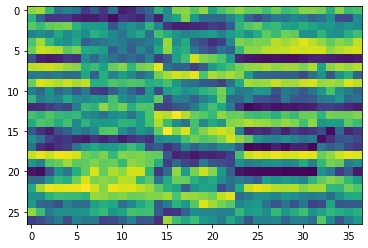

In [31]:
plt.imshow(out[0].detach().numpy().T,aspect='auto',interpolation='nearest')

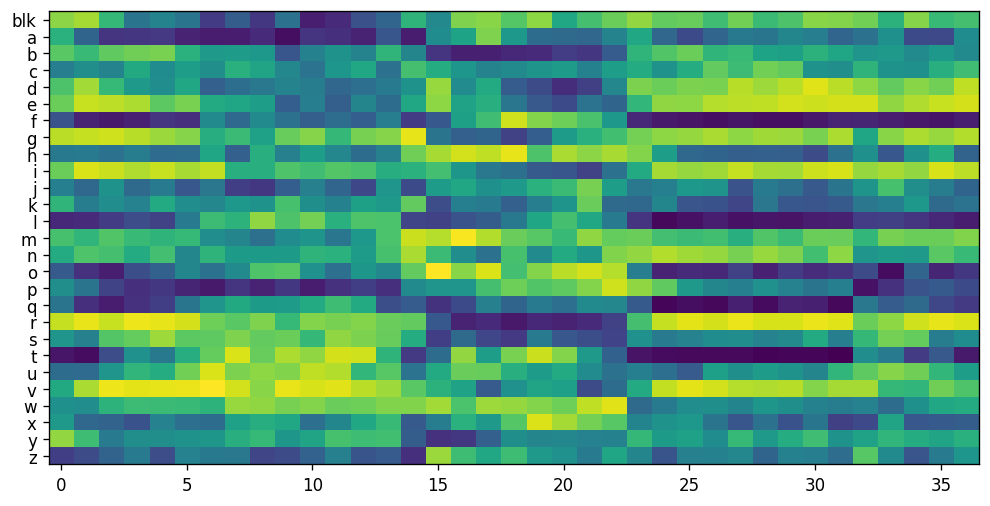

In [32]:
plt.figure(figsize=(10,5),dpi=120)
plt.imshow(out[0].detach().numpy().T,aspect='auto')
ax = plt.gca()
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.show()

In [33]:
[[char_set['s'],char_set['e'],char_set['t']]]

[[19, 5, 20]]

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/5000 [00:00<?, ?it/s]

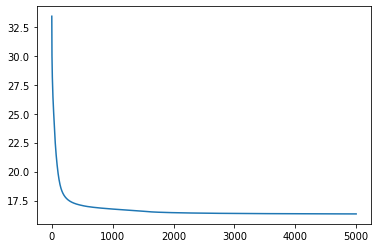

In [34]:
from tqdm.auto import tqdm


num_epoch =5000 
ctc_loss = nn.CTCLoss()  # CTC loss, loss_fn

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)  # set -> 19,5,20
target_lengths=torch.tensor([[3]])  # target length = 3 
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")  #datset 에 위치해야하는 statement 
batch = [[y,target]]
print(target.shape,target.dtype)
#print(model.rnn.all_weights)
model=RNNModel()
model.to('cuda')
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
#out = torch.randn((97,27))
losses = []
#ctc_loss = nn.CTCLoss()
#input_lengths = torch.full(size=(1,), fill_value=37, dtype=torch.long)
input_lengths = torch.tensor(37)
pbar = tqdm(range(num_epoch))
for e in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to('cuda')
    y = y.to('cuda')
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)

In [35]:
y,sr = torchaudio.load("set.wav")
model.to('cpu')
out = model(y)

In [36]:
len(char_list)

27

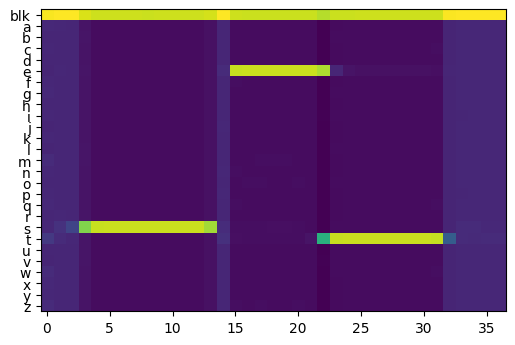

In [37]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.imshow(out.detach().numpy()[0].T,aspect='auto')
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
#plt.colorbar()
plt.show()


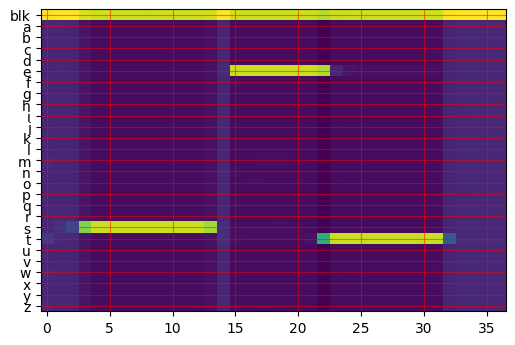

In [38]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.imshow(out.detach().numpy()[0].T,aspect='auto')
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.grid(alpha=0.5,color='r')
plt.show()

In [39]:
def plot_ctc_result(out,epoch):
  fig, ax = plt.subplots(1,1,dpi=100)
  ax.set_title(f"{epoch} epoch result")
  ax.imshow(out.detach().numpy()[0].T,aspect='auto')
  ax.set_yticks(range(0,27))
  ax.set_yticklabels(char_list)
  plt.grid(alpha=0.5,color='r')
  plt.show()

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/5000 [00:00<?, ?it/s]

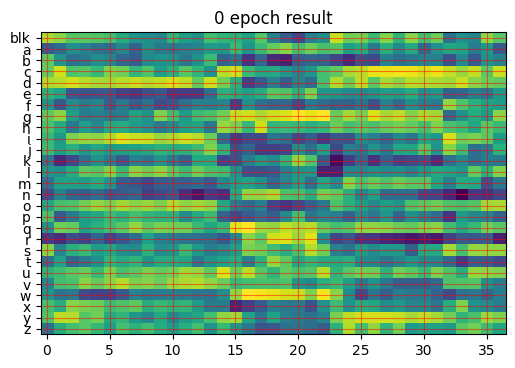

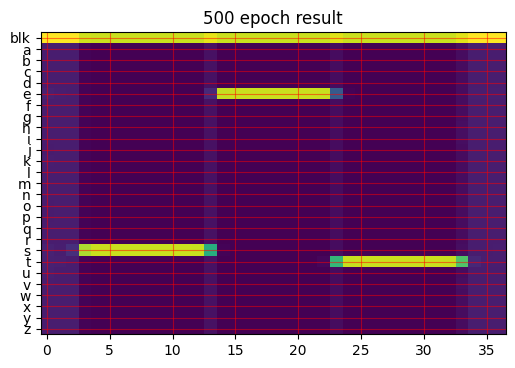

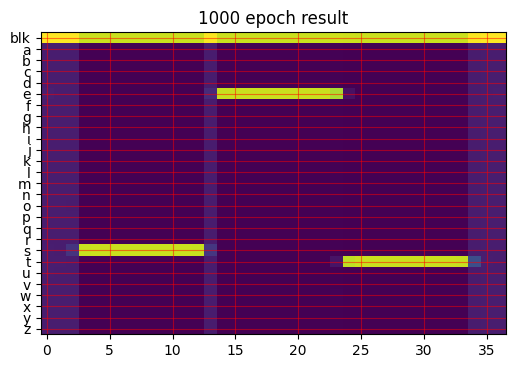

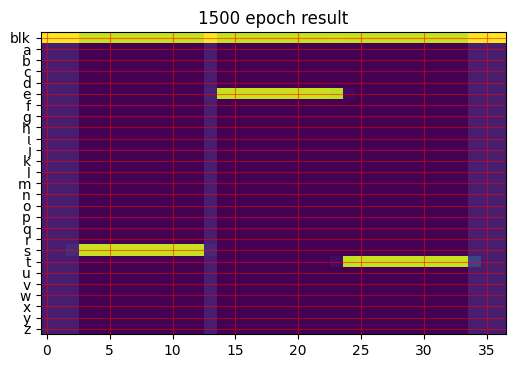

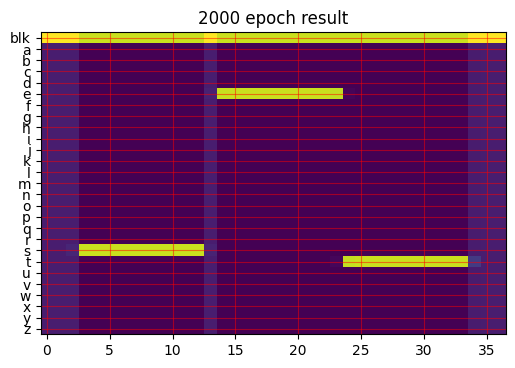

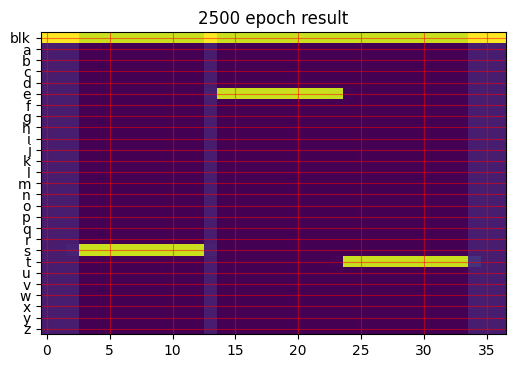

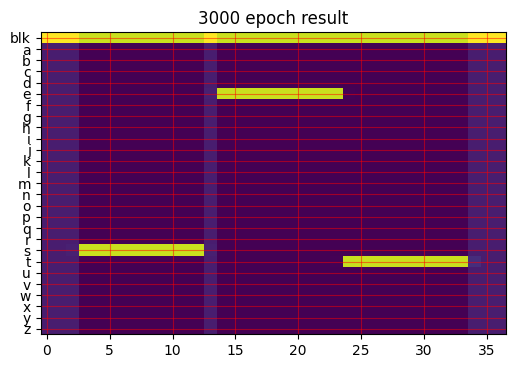

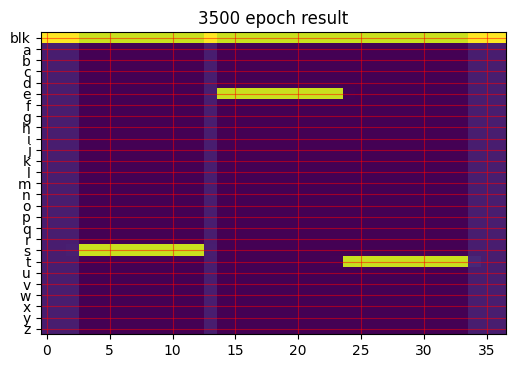

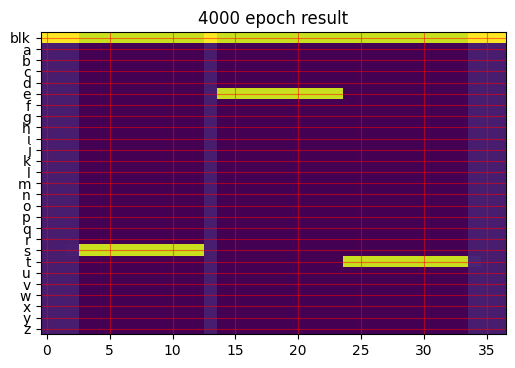

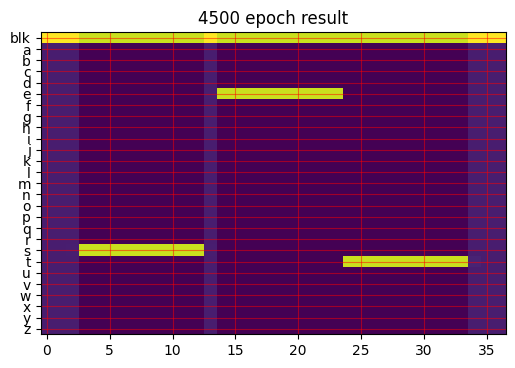

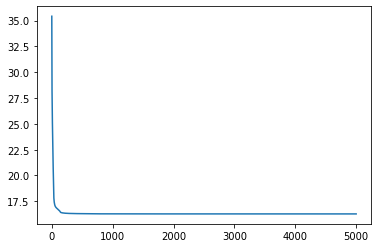

In [40]:
from tqdm.auto import tqdm


T=97
C=27

num_epoch =5000
ctc_loss = nn.CTCLoss()

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)
target_lengths=torch.tensor([[3]])
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")
batch = [[y,target]]
print(target.shape,target.dtype)
#print(model.rnn.all_weights)
model=RNNModel()
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#out = torch.randn((97,27))
losses = []
ctc_loss = nn.CTCLoss()
#input_lengths = torch.full(size=(1,), fill_value=37, dtype=torch.long)
input_lengths = torch.tensor(37 )
pbar = tqdm(range(num_epoch))
for epoch in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to('cuda')
    y = y.to('cuda')
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0 :
      plot_ctc_result(pred.cpu(),epoch)
    
plt.plot(losses)

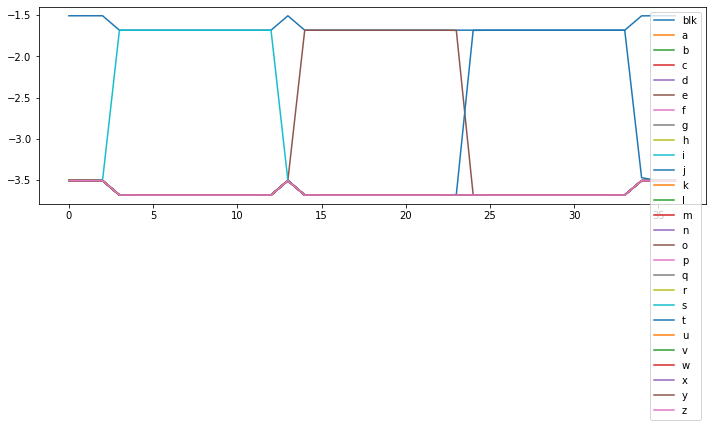

In [41]:
data = pred[0].cpu().detach().numpy()
plt.figure(figsize=(10,5))
plt.plot(data)
plt.legend(char_list)
plt.tight_layout()

In [42]:
import plotly.graph_objects as go
data = torch.exp(pred[0].cpu().detach()).numpy()
fig = go.Figure()
for idx,char_prob in enumerate(data.T):
  fig.add_trace(go.Line(y = char_prob,name=char_list[idx]))
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


